In [6]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from scipy.optimize import fsolve
import scipy

In [7]:
alpha = 0.5; Re = 1; epsilon =0.1; Bo=epsilon; Ca=epsilon; Ma = 0; k = 1/epsilon; Lambda = 0.1
N = 5;
r_list = np.linspace(alpha, 1, N); h = r_list[1]-r_list[0]

In [8]:
def w_0(r):
    return 1/4*(2*np.log(r/alpha)-(r**2-alpha**2))
def w_0_prime(r):
    return 1/2*(1/r-r)

$$\operatorname{Re}\frac{2k^2}{r}f(r)\frac{dw_0(r)}{dr}=\nabla^2p=\frac{d^2p}{dr^2}+\frac{1}{r}\frac{dp}{dr}-k^2p$$

(5, 11)

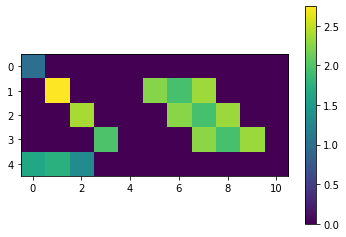

In [9]:
matrix_f_eq1 = np.zeros((N,N), dtype=float)
matrix_p_eq1 = np.zeros((N,N), dtype=float)
matrix_f_eq1[0,0] = 1; # no_slip for u at the wall (a_0=0)
#matrix_b_continuity[-1,0] =1; # no_slip for u at the wall (b_0=0)
for j, r in enumerate(r_list[1:-1]):
    j=j+1
    matrix_f_eq1[j,j] = 2*k**2/r*w_0_prime(r)*Re
    matrix_p_eq1[j, j-1] = 1/(2*h*r)-1/h**2
    matrix_p_eq1[j,j] = 2/h**2-k**2
    matrix_p_eq1[j,j+1] =  -1/h**2-1/(2*r*h)

# df/dr =0
matrix_f_eq1[-1, 0] =-3/2/h
matrix_f_eq1[-1, 1] =2/h
matrix_f_eq1[-1, 2] =-1/2/h
matrix_eq1 = np.concatenate([matrix_f_eq1, matrix_p_eq1, np.zeros((N,1))], axis=1)
plt.imshow((np.abs(matrix_eq1))**(1/5)); plt.colorbar()
np.shape(matrix_eq1)

(6, 11)

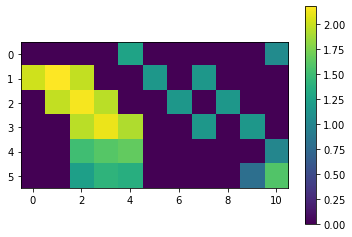

In [10]:
matrix_f_eq2 = np.zeros((N+1,N), dtype=complex)
matrix_p_eq2 = np.zeros((N+1,N+1), dtype=complex)

for j, r in enumerate(r_list[1:-1]):
    j=j+1
    matrix_f_eq2[j,j-1] = -1j*k/(2*h*r**2)-1j*k/(r*h**2)
    matrix_f_eq2[j,j] = -2*1j/r**3 + 2*1j*k/(r*h**2) +1j*k**3/3+Re/r*(Lambda*1j-k**2*w_0(r))
    matrix_f_eq2[j, j+1] = 1j*k/(2*h*r**2)-1j*k/(r*h**2)
    matrix_p_eq2[j, j-1] = -1/(2*h)
    matrix_p_eq2[j,j+1] =  1/(2*h)

#kinematic
matrix_f_eq2[0, N-1] = -1j*k
matrix_p_eq2[0, -1] = 1j*k*w_0(1)+Lambda

#tangential stress
matrix_f_eq2[N-1, N-3] = 1/(2*h)-1/h**2
matrix_f_eq2[N-1, N-2] = 2/h**2-2/h
matrix_f_eq2[N-1, N-1] = 3/(2*h)-1/h**2-k**2
matrix_p_eq2[N-1, -1] = -1

#normal stress
matrix_f_eq2[-1, N-3] = -1j*k*Ca/h
matrix_f_eq2[-1, N-2] = 4*1j*k*Ca/h
matrix_f_eq2[-1, N-1] = -3*1j*k*Ca/h+2*1j*k*Ca
matrix_p_eq2[-1, N-1] = Bo
matrix_p_eq2[-1,-1] = 1-2*Ma-k**2
matrix_eq2 = np.concatenate([matrix_f_eq2, matrix_p_eq2], axis=1)
plt.imshow(np.abs(matrix_eq2)**(1/10)); plt.colorbar()
np.shape(matrix_eq2)

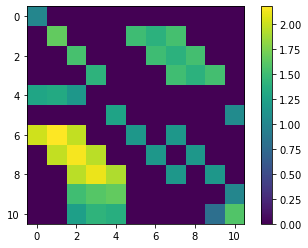

In [11]:
matrix_big = np.concatenate([matrix_eq1, matrix_eq2], axis=0)
plt.imshow((np.abs(matrix_big))**(1/10)); plt.colorbar()

In [12]:
# now we write that into a big function
def build_matrix(Lambda,k,N, Re=0):
    matrix_f_eq1 = np.zeros((N,N), dtype=float)
    matrix_p_eq1 = np.zeros((N,N), dtype=float)

    matrix_f_eq1[0,0] = 1; # no_slip for u at the wall (a_0=0)
    r_list = np.linspace(alpha, 1, N); h=r_list[1]-r_list[0]
    #matrix_b_continuity[-1,0] =1; # no_slip for u at the wall (b_0=0)
    for j, r in enumerate(r_list[1:-1]):
        j=j+1
        matrix_f_eq1[j,j] = 2*k**2/r*w_0_prime(r)*Re
        matrix_p_eq1[j, j-1] = 1/(2*h*r)-1/h**2
        matrix_p_eq1[j,j] = 2/h**2-k**2
        matrix_p_eq1[j,j+1] =  -1/h**2-1/(2*r*h)

    # df/dr =0
    matrix_f_eq1[-1, 0] =-3/2/h
    matrix_f_eq1[-1, 1] =2/h
    matrix_f_eq1[-1, 2] =-1/2/h
    matrix_eq1 = np.concatenate([matrix_f_eq1, matrix_p_eq1, np.zeros((N,1))], axis=1)
    matrix_f_eq2 = np.zeros((N+1,N), dtype=complex)
    matrix_p_eq2 = np.zeros((N+1,N+1), dtype=complex)
    for j, r in enumerate(r_list[1:-1]):
        j=j+1
        matrix_f_eq2[j,j-1] = -1j*k/(2*h*r**2)-1j*k/(r*h**2)
        matrix_f_eq2[j,j] = -2*1j/r**3 + 2*1j*k/(r*h**2) +1j*k**3/3+Re/r*(Lambda*1j-k**2*w_0(r))
        matrix_f_eq2[j, j+1] = 1j*k/(2*h*r**2)-1j*k/(r*h**2)
        matrix_p_eq2[j, j-1] = -1/(2*h)
        matrix_p_eq2[j,j+1] =  1/(2*h)

    #kinematic
    matrix_f_eq2[0, N-1] = -1j*k
    matrix_p_eq2[0, -1] = 1j*k*w_0(1) - Lambda

    #tangential stress
    matrix_f_eq2[N-1, N-3] = 1/(2*h)-1/h**2
    matrix_f_eq2[N-1, N-2] = 2/h**2-2/h
    matrix_f_eq2[N-1, N-1] = 3/(2*h)-1/h**2-k**2
    matrix_p_eq2[N-1, -1] = -1

    #normal stress
    matrix_f_eq2[-1, N-3] = -1j*k*Ca/h
    matrix_f_eq2[-1, N-2] = 4*1j*k*Ca/h
    matrix_f_eq2[-1, N-1] = -3*1j*k*Ca/h+2*1j*k*Ca
    matrix_p_eq2[-1, N-1] = Bo
    matrix_p_eq2[-1,-1] = 1-2*Ma-k**2
    matrix_eq2 = np.concatenate([matrix_f_eq2, matrix_p_eq2], axis=1)
    return np.concatenate([matrix_eq1, matrix_eq2], axis=0)



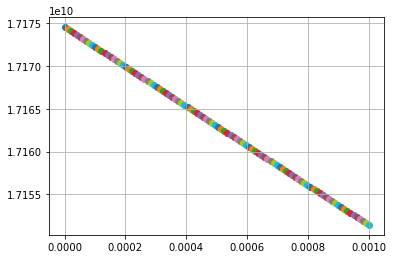

In [13]:
for x in np.linspace(0, .001, 100):
    plt.scatter(x,abs(np.linalg.det(build_matrix(x, 0.5, 5))))
    
plt.grid()

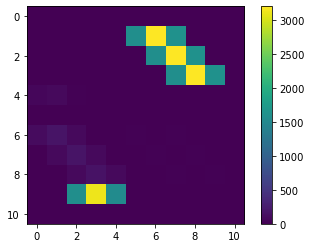


0.2479270480956885
0 (5.160110382738946e-06+0.0005507179571108787j)


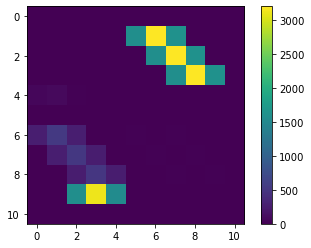


29.840317321158746
10 (4.5585267532909385e-05+0.0016593768667283264j)


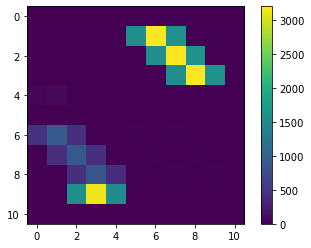


185.0263693394671
20 (0.0001210915245640668+0.0027693683536391257j)


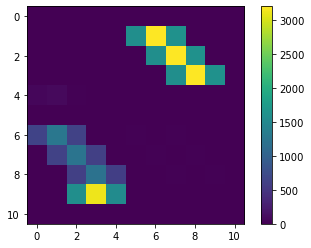


3077.199826187137
30 (0.00022059758285758625+0.0038794758037618447j)


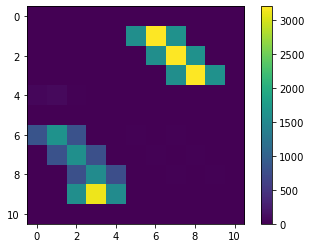


2820.4820169842574
40 (0.0003274495123820342+0.004989562169581498j)


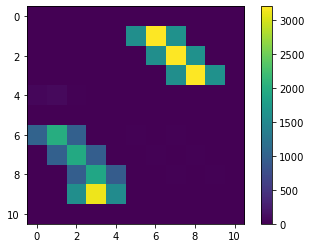


18635.485330361767
50 (0.0004194267215256487+0.00609957554495261j)


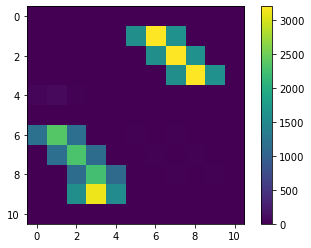


31945.755461735407
60 (0.00046875232730988765+0.007209482882215666j)


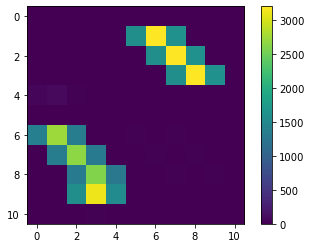


9215.2706084953
70 (0.0004421062570531873+0.008319257233943746j)


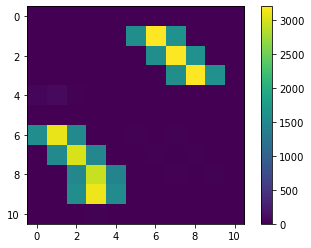


40251.21351414773
80 (0.0003006410001490336+0.009428874065773448j)


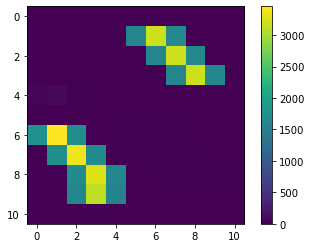


2095.411968160169
90 (-2.3286787592614487e-31+0.010538309905680351j)


In [14]:
alpha = 0.9; Re = 0; epsilon = 0.1; Bo = epsilon; Ca = epsilon; Ma = 0;
N = 5;
D_ = 1 - 2*Ma
r_list = np.linspace(alpha, 1, N); h = r_list[1]-r_list[0]
kappa_vect = np.linspace(0.05,1, 10)
#k_vect = kappa_vect/epsilon
Lambda_vect = np.zeros_like(kappa_vect, dtype='complex')
for j,k in enumerate(kappa_vect):
    def build_matrix(Lambda):
        matrix_f_eq1 = np.zeros((N,N), dtype=float)
        matrix_p_eq1 = np.zeros((N,N), dtype=float)

        matrix_f_eq1[0,0] = 1; # no_slip for u at the wall (a_0=0)
        #matrix_b_continuity[-1,0] =1; # no_slip for u at the wall (b_0=0)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq1[j,j] = 2*k**2/r*w_0_prime(r)*Re
            matrix_p_eq1[j, j-1] = 1/(2*h*r)-1/h**2
            matrix_p_eq1[j,j] = 2/h**2-k**2
            matrix_p_eq1[j,j+1] =  -1/h**2-1/(2*r*h)

        # df/dr =0
        matrix_f_eq1[-1, 0] =-3/2/h
        matrix_f_eq1[-1, 1] =2/h
        matrix_f_eq1[-1, 2] =-1/2/h
        matrix_eq1 = np.concatenate([matrix_f_eq1, matrix_p_eq1, np.zeros((N,1))], axis=1)
        matrix_f_eq2 = np.zeros((N+1,N), dtype=complex)
        matrix_p_eq2 = np.zeros((N+1,N+1), dtype=complex)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq2[j,j-1] = -1j*k/(2*h*r**2)-1j*k/(r*h**2)
            matrix_f_eq2[j,j] = -2*1j/r**3 + 2*1j*k/(r*h**2) +1j*k**3/3+Re/r*(Lambda*1j*k-k**2*w_0(r))
            matrix_f_eq2[j, j+1] = 1j*k/(2*h*r**2)-1j*k/(r*h**2)
            matrix_p_eq2[j, j-1] = -1/(2*h)
            matrix_p_eq2[j,j+1] =  1/(2*h)

        #kinematic
        matrix_f_eq2[0, N-1] = -1j*k
        matrix_p_eq2[0, -1] = 1j*k*w_0(1)-Lambda

        #tangential stress
        matrix_f_eq2[N-1, N-3] = 1/(2*h)-1/h**2
        matrix_f_eq2[N-1, N-2] = 2/h**2-2/h
        matrix_f_eq2[N-1, N-1] = 3/(2*h)-1/h**2-k**2
        matrix_p_eq2[N-1, -1] = -1

        #normal stress
        matrix_f_eq2[-1, N-3] = -1j*k*Ca/h
        matrix_f_eq2[-1, N-2] = 4*1j*k*Ca/h
        matrix_f_eq2[-1, N-1] = -3*1j*k*Ca/h+2*1j*k*Ca
        matrix_p_eq2[-1, N-1] = Bo
        matrix_p_eq2[-1,-1] = 1-2*Ma-k**2
        matrix_eq2 = np.concatenate([matrix_f_eq2, matrix_p_eq2], axis=1)
        return np.concatenate([matrix_eq1, matrix_eq2], axis=0)
    
    def f(Lambda_):
        return np.linalg.det(build_matrix(Lambda_))
    
    Lambda_vect[j] = scipy.optimize.root_scalar(f, x0= -1,x1=10,method='secant', xtol= 1e-5).root
    #Lambda_vect[j] = scipy.optimize.root_scalar(f, bracket=[0,.001],method='bisect', xtol= 1e-5).root
    plt.imshow(np.abs(build_matrix(Lambda_vect[j]))); plt.colorbar();plt.show()
    print()
    print(np.abs(f(Lambda_vect[j])))
    #plt.imshow(np.abs(build_matrix(Lambda_vect[j]))**(1/100));plt.colorbar(); plt.show()
    print(int(j/len(kappa_vect)*100), Lambda_vect[j])

In [17]:
# in this code I multiply the equations by the appropiate powers of r and h to reduce the magnitute
#of the matrix entries. 

alpha = 0.5; Re = 0; epsilon = 0.1; Bo = epsilon; Ca = epsilon; Ma = 0;
N = 50;
D_ = 1 - 2*Ma
r_list = np.linspace(alpha, 1, N); h = r_list[1]-r_list[0]
kappa_vect = np.linspace(0.05,1, 40)
k_vect = kappa_vect/epsilon
Lambda_vect = np.zeros_like(kappa_vect, dtype='complex')
for j,k in enumerate(kappa_vect):
    def build_matrix_simple(Lambda):
        matrix_f_eq1 = np.zeros((N,N), dtype=float)
        matrix_p_eq1 = np.zeros((N,N), dtype=float)

        matrix_f_eq1[0,0] = 1; # no_slip for u at the wall (a_0=0)
        #matrix_b_continuity[-1,0] =1; # no_slip for u at the wall (b_0=0)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq1[j,j] = 2*k**2*w_0_prime(r)*Re*h**2
            matrix_p_eq1[j, j-1] = (1/(2*h)-1/h**2*r)*h**2
            matrix_p_eq1[j,j] = (2/h**2*r-k**2*r)*h**2
            #print(matrix_p_eq1[j,j])
            matrix_p_eq1[j,j+1] =  (-1/h**2*r-1/(2*h))*h**2

        # df/dr =0
        matrix_f_eq1[-1, 0] =-3/2
        matrix_f_eq1[-1, 1] =2
        matrix_f_eq1[-1, 2] =-1/2
        matrix_eq1 = np.concatenate([matrix_f_eq1, matrix_p_eq1, np.zeros((N,1))], axis=1)
        matrix_f_eq2 = np.zeros((N+1,N), dtype=complex)
        matrix_p_eq2 = np.zeros((N+1,N+1), dtype=complex)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq2[j,j-1] = (-1j*k/(2*h*r**2)-1j*k/(r*h**2))*r**3*h**2
            matrix_f_eq2[j,j] = (-2*1j/r**3 + 2*1j*k/(r*h**2) +1j*k**3/3+Re/r*(Lambda*1j*k-k**2*w_0(r)))*r**3*h**2
            matrix_f_eq2[j, j+1] = (1j*k/(2*h*r**2)-1j*k/(r*h**2))*r**3*h**2
            matrix_p_eq2[j, j-1] = -1/(2*h)*r**3*h**2
            matrix_p_eq2[j,j+1] =  1/(2*h)*r**3*h**2

        #kinematic
        matrix_f_eq2[0, N-1] = -1j*k
        matrix_p_eq2[0, -1] = 1j*k*w_0(1)-Lambda

        #tangential stress
        matrix_f_eq2[N-1, N-3] = (1/(2*h)-1/h**2)*h**2
        matrix_f_eq2[N-1, N-2] = (2/h**2-2/h)*h**2
        matrix_f_eq2[N-1, N-1] = (3/(2*h)-1/h**2-k**2)*h**2
        matrix_p_eq2[N-1, -1] = (-1)*h**2

        #normal stress
        matrix_f_eq2[-1, N-3] = -1j*k*Ca/h*h
        matrix_f_eq2[-1, N-2] = 4*1j*k*Ca/h*h
        matrix_f_eq2[-1, N-1] = (-3*1j*k*Ca/h+2*1j*k*Ca)*h
        matrix_p_eq2[-1, N-1] = Bo*h
        matrix_p_eq2[-1,-1] = (1-2*Ma-k**2)*h
        matrix_eq2 = np.concatenate([matrix_f_eq2, matrix_p_eq2], axis=1)
        return np.concatenate([matrix_eq1, matrix_eq2], axis=0)
    
    def f(Lambda_):
        return np.linalg.det(build_matrix_simple(Lambda_))
    
    Lambda_vect[j] = scipy.optimize.root_scalar(f, x0= -1,x1=1,method='secant', xtol= 1e-2).root
    #Lambda_vect[j] = scipy.optimize.root_scalar(f, bracket=[0,.001],method='bisect', xtol= 1e-5).root
    #plt.imshow(np.abs(build_matrix_simple(Lambda_vect[j]))); plt.colorbar();plt.show()
    print(np.abs(f(Lambda_vect[j])), np.abs(f(0)))
    print(int(j/len(kappa_vect)*100), Lambda_vect[j].real)
    #plt.imshow(np.abs(build_matrix(Lambda_vect[j]))**(1/100));plt.colorbar(); plt.show()
    
    print()

2.7986470149054044e-104 1.9426275277903834e-89
0 -0.00038450740006904145

1.9953131986027645e-94 6.515832863536529e-81
2 -0.001244542111951684

4.979357986188834e-90 3.3425023275182664e-75
5 -0.0033498853967973328

0.0 2.824100139405384e-70
7 -0.007889786671459889

0.0 2.8568531530014287e-66
10 -0.01756173120745843

9.105394583535863e-77 6.156737771488043e-63
12 -0.039954310278607096

4.9342349923337275e-74 4.491923574426535e-60
15 -0.10809357897608526

1.7712112018436704e-71 1.4619070586439297e-57
17 -0.9533433371537603

0.0 2.5397930657866866e-55
20 0.29990279943604226

1.6303174716349058e-67 2.6677432392469616e-53
22 0.17579145260716142

0.0 1.8542330149105038e-51
25 0.1444511587677825

5.1227234275592306e-65 9.125580240772165e-50
27 0.13292703654091745

0.0 3.350242734908123e-48
30 0.1288754779088231

8.592560954443048e-62 9.559504588894106e-47
32 0.12840911650072043

7.15508012631138e-60 2.190917033234295e-45
35 0.12988653304632533

1.2389068110812319e-58 4.142678526295592e-44
37 

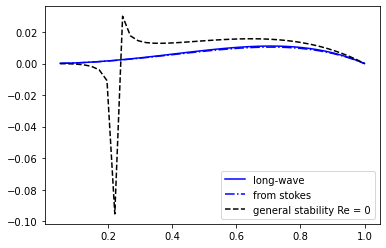

In [18]:
lambda_vect_thin = k_vect**2/3*(D_-epsilon**2*k_vect**2)*(1-alpha)**3
lambda_vect = k_vect**2/16*(epsilon**2*k_vect**2-D_)*((alpha**2-1)**2-2*(alpha**2-1-2*np.log(alpha)))

plt.plot(epsilon*k_vect, epsilon**2*lambda_vect, label='long-wave', color='blue')
plt.plot(k_vect*epsilon,epsilon**2*lambda_vect_thin,'-.' ,label='from stokes', color='blue')
plt.plot(kappa_vect, epsilon*Lambda_vect.real, '--', label ='general stability Re = 0',color='black')
plt.legend()

# Arnoldi Method/ Generalized EVP


# Different Method

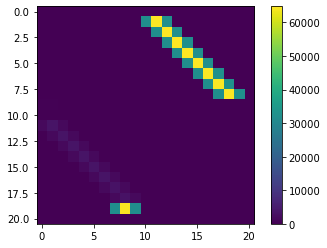

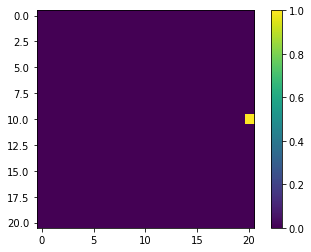

[8.80410758e-07            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
0.0


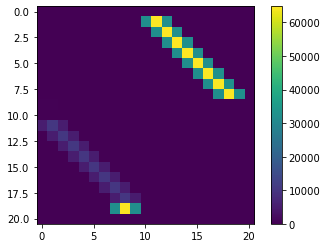

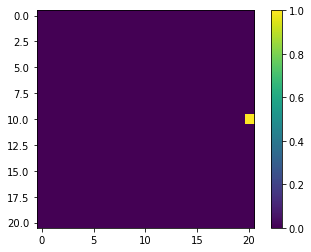

[8.15025023e-06            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
10.0


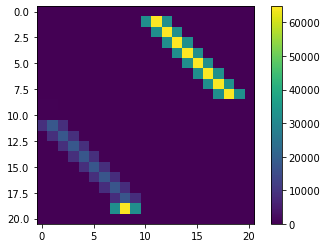

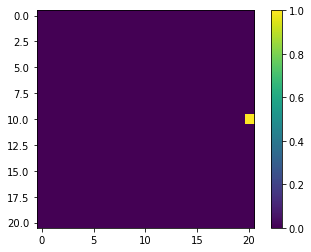

[2.18360506e-05            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
20.0


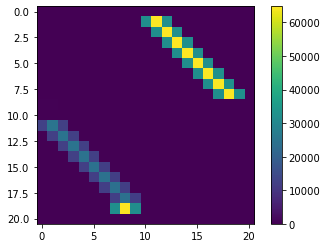

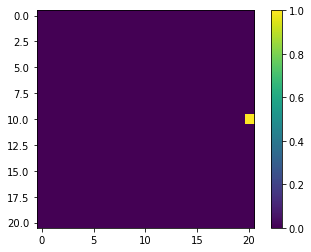

[3.99255957e-05            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
30.0


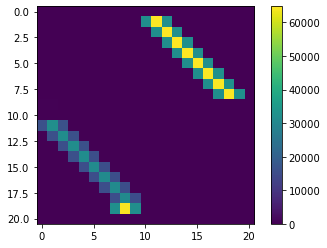

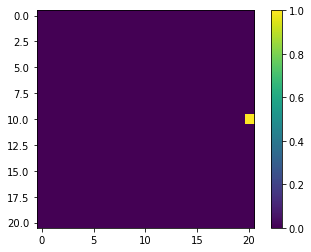

[5.93889949e-05            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
40.0


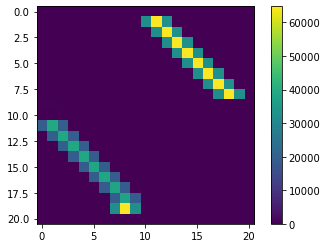

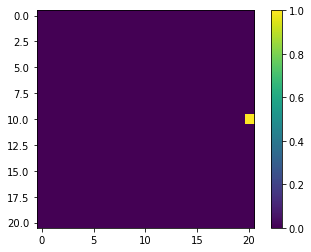

[7.61784795e-05            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
50.0


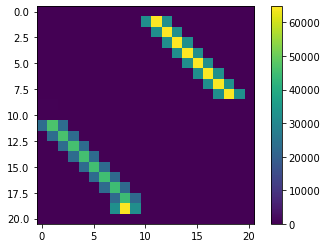

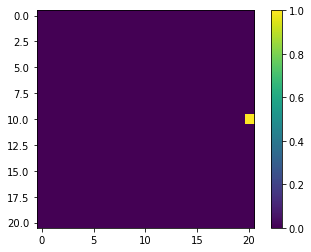

[8.52281457e-05            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
60.0


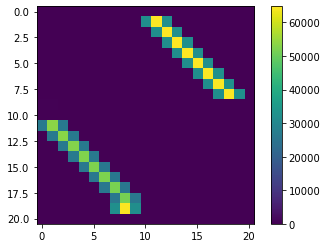

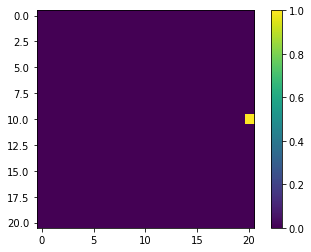

[8.04536344e-05            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
70.0


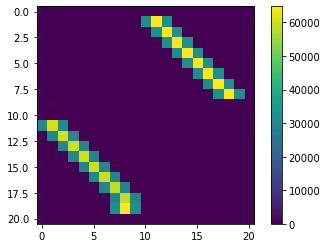

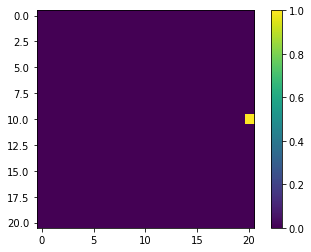

[5.47517473e-05            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf            inf            inf            inf
            inf]
80.0


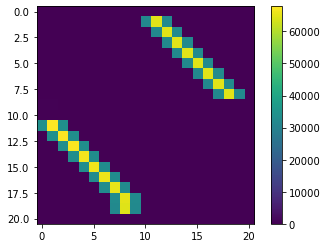

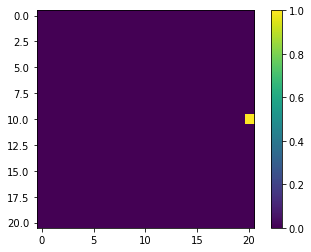

[ 0. inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf inf
 inf inf inf]
90.0


In [153]:
alpha = 0.95; Re =0; epsilon = 0.1; Bo = epsilon; Ca = epsilon; Ma = 0;
N = 10;
D_ = 1 - 2*Ma
r_list = np.linspace(alpha, 1, N); h = r_list[1]-r_list[0]
kappa_vect = np.linspace(0.05,1, 10)
#k_vect = kappa_vect/epsilon
Lambda_vect = np.zeros_like(kappa_vect, dtype='complex')
for j,k in enumerate(kappa_vect):
    def build_matrix_arnoldi():
        matrix_f_eq1 = np.zeros((N,N), dtype=float)
        matrix_p_eq1 = np.zeros((N,N), dtype=float)

        matrix_f_eq1[0,0] = 1; # no_slip for u at the wall (a_0=0)
        #matrix_b_continuity[-1,0] =1; # no_slip for u at the wall (b_0=0)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq1[j,j] = 2*k**2/r*w_0_prime(r)*Re
            matrix_p_eq1[j, j-1] = 1/(2*h*r)-1/h**2
            matrix_p_eq1[j,j] = 2/h**2-k**2
            matrix_p_eq1[j,j+1] =  -1/h**2-1/(2*r*h)

        # df/dr =0
        matrix_f_eq1[-1, 0] =-3/2/h
        matrix_f_eq1[-1, 1] =2/h
        matrix_f_eq1[-1, 2] =-1/2/h
        matrix_eq1 = np.concatenate([matrix_f_eq1, matrix_p_eq1, np.zeros((N,1))], axis=1)
        
        matrix_f_eq2 = np.zeros((N+1,N), dtype=complex)
        matrix_p_eq2 = np.zeros((N+1,N+1), dtype=complex)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq2[j,j-1] = -1j*k/(2*h*r**2)-1j*k/(r*h**2)
            matrix_f_eq2[j,j] = -2*1j/r**3 + 2*1j*k/(r*h**2) +1j*k**3/3+Re/r*(-k**2*w_0(r))
            matrix_f_eq2[j, j+1] = 1j*k/(2*h*r**2)-1j*k/(r*h**2)
            matrix_p_eq2[j, j-1] = -1/(2*h)
            matrix_p_eq2[j,j+1] =  1/(2*h)

        #kinematic
        matrix_f_eq2[0, N-1] = -1j*k
        matrix_p_eq2[0, -1] = 1j*k*w_0(1)

        #tangential stress
        matrix_f_eq2[N-1, N-3] = 1/(2*h)-1/h**2
        matrix_f_eq2[N-1, N-2] = 2/h**2-2/h
        matrix_f_eq2[N-1, N-1] = 3/(2*h)-1/h**2-k**2
        matrix_p_eq2[N-1, -1] = -1 

        #normal stress
        matrix_f_eq2[-1, N-3] = -1j*k*Ca/h
        matrix_f_eq2[-1, N-2] = 4*1j*k*Ca/h
        matrix_f_eq2[-1, N-1] = -3*1j*k*Ca/h+2*1j*k*Ca
        matrix_p_eq2[-1, N-1] = Bo
        matrix_p_eq2[-1,-1] = 1-2*Ma-k**2
        matrix_eq2 = np.concatenate([matrix_f_eq2, matrix_p_eq2], axis=1)
        
        matrix_f_RHS_2 = np.zeros((N+1,N), dtype = complex) 
        matrix_p_RHS_2 = np.zeros((N+1,N+1), dtype = complex)
        
        matrix_p_RHS_2[0, -1] = 1
        for j, r in enumerate(r_list[1:-1]):
            matrix_f_RHS_2[j,j] = Re/r*1j*k
        matrix_RHS_1 = np.zeros_like(matrix_eq1)
        matrix_RHS_2 = np.concatenate([matrix_f_RHS_2, matrix_p_RHS_2], axis=1)
        
        return np.concatenate([matrix_eq1, matrix_eq2], axis=0), np.concatenate([matrix_RHS_1, matrix_RHS_2], axis=0)
    
    A,B = build_matrix_arnoldi()
    #print(A)
    plt.imshow(np.abs(A)); plt.colorbar()
    plt.show()
    plt.imshow(np.abs(B)); plt.colorbar()
    plt.show()
    evals = scipy.linalg.eigvals(A,B).real
    print(evals)
    Lambda_vect[j] = np.max(evals[~np.isinf(evals)])
    print(j/len(kappa_vect)*100)

In [273]:
#better behaved matrix
alpha = 0.95; Re =0; epsilon = 0.1; Bo = epsilon; Ca = epsilon; Ma = 1/2;
N = 100;
D_ = 1 - 2*Ma
r_list = np.linspace(alpha, 1, N); h = r_list[1]-r_list[0]
kappa_vect = np.linspace(0.05,1, 40)
k_vect = kappa_vect/epsilon
Lambda_vect = np.zeros_like(kappa_vect, dtype='complex')
for j,k in enumerate(kappa_vect):
    def build_matrix_arnoldi():
        matrix_f_eq1 = np.zeros((N,N), dtype=float)
        matrix_p_eq1 = np.zeros((N,N), dtype=float)

        matrix_f_eq1[0,0] = 1; # no_slip for u at the wall (a_0=0)
        #matrix_b_continuity[-1,0] =1; # no_slip for u at the wall (b_0=0)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq1[j,j] = 2*k**2/r*w_0_prime(r)*Re*h**2
            matrix_p_eq1[j, j-1] = (1/(2*h*r)-1/h**2)*h**2
            matrix_p_eq1[j,j] = (2/h**2-k**2)*h**2
            matrix_p_eq1[j,j+1] =  (-1/h**2-1/(2*r*h))*h**2

        # df/dr =0
        matrix_f_eq1[-1, 0] =-3/2
        matrix_f_eq1[-1, 1] =2
        matrix_f_eq1[-1, 2] =-1/2
        matrix_eq1 = np.concatenate([matrix_f_eq1, matrix_p_eq1, np.zeros((N,1))], axis=1)
        
        matrix_f_eq2 = np.zeros((N+1,N), dtype=complex)
        matrix_p_eq2 = np.zeros((N+1,N+1), dtype=complex)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq2[j,j-1] = (-1j*k/(2*h*r**2)-1j*k/(r*h**2))*h**2
            matrix_f_eq2[j,j] = (-2*1j/r**3 + 2*1j*k/(r*h**2) +1j*k**3/3+Re/r*(-k**2*w_0(r)))*h**2
            matrix_f_eq2[j, j+1] = (1j*k/(2*h*r**2)-1j*k/(r*h**2))*h**2
            matrix_p_eq2[j, j-1] = -1/(2*h)*h**2
            matrix_p_eq2[j,j+1] =  1/(2*h)*h**2

        #kinematic
        matrix_f_eq2[0, N-1] = -1j*k
        matrix_p_eq2[0, -1] = 1j*k*w_0(1)

        #tangential stress
        matrix_f_eq2[N-1, N-3] = (1/(2*h)-1/h**2)*h**2
        matrix_f_eq2[N-1, N-2] = (2/h**2-2/h)*h**2
        matrix_f_eq2[N-1, N-1] = (3/(2*h)-1/h**2-k**2)*h**2
        matrix_p_eq2[N-1, -1] = -1*h**2 

        #normal stress
        matrix_f_eq2[-1, N-3] = -1j*k*Ca/h*h
        matrix_f_eq2[-1, N-2] = 4*1j*k*Ca/h*h
        matrix_f_eq2[-1, N-1] = (-3*1j*k*Ca/h+2*1j*k*Ca)*h
        matrix_p_eq2[-1, N-1] = Bo*h
        matrix_p_eq2[-1,-1] = (1-2*Ma-k**2)*h
        matrix_eq2 = np.concatenate([matrix_f_eq2, matrix_p_eq2], axis=1)
        
        matrix_f_RHS_2 = np.zeros((N+1,N), dtype = complex) 
        matrix_p_RHS_2 = np.zeros((N+1,N+1), dtype = complex)
        
        matrix_p_RHS_2[0, -1] = 1
        for j, r in enumerate(r_list[1:-1]):
            matrix_f_RHS_2[j,j] = Re/r*1j*k*h**2
        matrix_RHS_1 = np.zeros_like(matrix_eq1)
        matrix_RHS_2 = np.concatenate([matrix_f_RHS_2, matrix_p_RHS_2], axis=1)
        
        return np.concatenate([matrix_eq1, matrix_eq2], axis=0), np.concatenate([matrix_RHS_1, matrix_RHS_2], axis=0)
    
    A,B = build_matrix_arnoldi()
    #print(A)
    
    
    #plt.imshow(np.abs(A)); plt.colorbar()
   # plt.show()
    #plt.imshow(np.abs(B)); plt.colorbar()
    #plt.show()
    evals = scipy.linalg.eigvals(A,B).real
    #print(evals)
    Lambda_vect[j] = np.max(evals[~np.isinf(evals)])
    print(j/len(kappa_vect)*100)

0.0
2.5
5.0
7.5
10.0
12.5
15.0
17.5
20.0
22.5
25.0
27.500000000000004
30.0
32.5
35.0
37.5
40.0
42.5
45.0
47.5
50.0
52.5
55.00000000000001
57.49999999999999
60.0
62.5
65.0
67.5
70.0
72.5
75.0
77.5
80.0
82.5
85.0
87.5
90.0
92.5
95.0
97.5


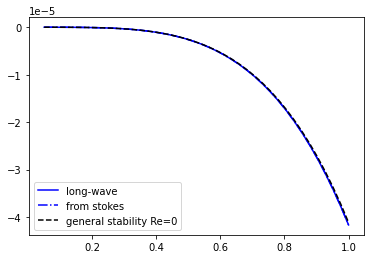

In [274]:
lambda_vect_thin = k_vect**2/3*(D_-epsilon**2*k_vect**2)*(1-alpha)**3
lambda_vect = k_vect**2/16*(epsilon**2*k_vect**2-D_)*((alpha**2-1)**2-2*(alpha**2-1-2*np.log(alpha)))
plt.plot(epsilon*k_vect, epsilon**2*lambda_vect, label='long-wave', color='blue')
plt.plot(k_vect*epsilon,epsilon**2*lambda_vect_thin,'-.' ,label='from stokes', color='blue')
plt.plot(kappa_vect, epsilon*Lambda_vect.real, '--', label ='general stability Re=0',color='black')
plt.legend()

In [189]:
## inverting the problem
alpha = 0.95; Re = 0; epsilon = 0.1; Bo = epsilon; Ca = epsilon; Ma = 0;
N = 20;
D_ = 1 - 2*Ma
r_list = np.linspace(alpha, 1, N); h = r_list[1]-r_list[0]
kappa_vect = np.linspace(0.05,1, 50)
#k_vect = kappa_vect/epsilon
Lambda_vect = np.zeros_like(kappa_vect, dtype='complex')
for j,k in enumerate(kappa_vect):
    def build_matrix_arnoldi():
        matrix_f_eq1 = np.zeros((N,N), dtype=float)
        matrix_p_eq1 = np.zeros((N,N), dtype=float)

        matrix_f_eq1[0,0] = 1; # no_slip for u at the wall (a_0=0)
        #matrix_b_continuity[-1,0] =1; # no_slip for u at the wall (b_0=0)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq1[j,j] = 2*k**2/r*w_0_prime(r)*Re
            matrix_p_eq1[j, j-1] = 1/(2*h*r)-1/h**2
            matrix_p_eq1[j,j] = 2/h**2-k**2
            matrix_p_eq1[j,j+1] =  -1/h**2-1/(2*r*h)

        # df/dr =0
        matrix_f_eq1[-1, 0] =-3/2/h
        matrix_f_eq1[-1, 1] =2/h
        matrix_f_eq1[-1, 2] =-1/2/h
        matrix_eq1 = np.concatenate([matrix_f_eq1, matrix_p_eq1, np.zeros((N,1))], axis=1)
        
        matrix_f_eq2 = np.zeros((N+1,N), dtype=complex)
        matrix_p_eq2 = np.zeros((N+1,N+1), dtype=complex)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq2[j,j-1] = -1j*k/(2*h*r**2)-1j*k/(r*h**2)
            matrix_f_eq2[j,j] = -2*1j/r**3 + 2*1j*k/(r*h**2) +1j*k**3/3+Re/r*(-k**2*w_0(r))
            matrix_f_eq2[j, j+1] = 1j*k/(2*h*r**2)-1j*k/(r*h**2)
            matrix_p_eq2[j, j-1] = -1/(2*h)
            matrix_p_eq2[j,j+1] =  1/(2*h)

        #kinematic
        matrix_f_eq2[0, N-1] = -1j*k
        matrix_p_eq2[0, -1] = 1j*k*w_0(1)

        #tangential stress
        matrix_f_eq2[N-1, N-3] = 1/(2*h)-1/h**2
        matrix_f_eq2[N-1, N-2] = 2/h**2-2/h
        matrix_f_eq2[N-1, N-1] = 3/(2*h)-1/h**2-k**2
        matrix_p_eq2[N-1, -1] = -1 

        #normal stress
        matrix_f_eq2[-1, N-3] = -1j*k*Ca/h
        matrix_f_eq2[-1, N-2] = 4*1j*k*Ca/h
        matrix_f_eq2[-1, N-1] = -3*1j*k*Ca/h+2*1j*k*Ca
        matrix_p_eq2[-1, N-1] = Bo
        matrix_p_eq2[-1,-1] = 1-2*Ma-k**2
        matrix_eq2 = np.concatenate([matrix_f_eq2, matrix_p_eq2], axis=1)
        
        matrix_f_RHS_2 = np.zeros((N+1,N), dtype = complex) 
        matrix_p_RHS_2 = np.zeros((N+1,N+1), dtype = complex)
        
        matrix_p_RHS_2[0, -1] = 1
        for j, r in enumerate(r_list[1:-1]):
            matrix_f_RHS_2[j,j] = Re/r*1j*k
        matrix_RHS_1 = np.zeros_like(matrix_eq1)
        matrix_RHS_2 = np.concatenate([matrix_f_RHS_2, matrix_p_RHS_2], axis=1)
        
        return np.concatenate([matrix_eq1, matrix_eq2], axis=0), np.concatenate([matrix_RHS_1, matrix_RHS_2], axis=0)
    
    A,B = build_matrix_arnoldi()
    #print(A)
    #plt.imshow(np.abs(A)); plt.colorbar()
    #plt.show()
    #plt.imshow(np.abs(B)); plt.colorbar()
    #plt.show()
    evals_complex = scipy.linalg.eigvals(B,A)
    #print(evals_complex)
    evals_filtered = evals_complex[np.abs(evals_complex)>1e-16]
    lambdas = evals_filtered.real/(np.abs(evals_filtered)**2)
    print(lambdas)
    Lambda_vect[j] = np.max(lambdas)
    print(j/len(kappa_vect)*100)

[9.88316593e-07]
0.0
[1.88238807e-06]
2.0
[3.05233518e-06]
4.0
[4.4934152e-06]
6.0
[6.20873004e-06]
8.0
[8.18057055e-06]
10.0
[1.03978861e-05 2.94867775e-03]
12.0
[1.28597836e-05]
14.000000000000002
[ 1.55470165e-05 -3.77788574e-03]
16.0
[1.84459807e-05]
18.0
[2.15521453e-05]
20.0
[2.48369694e-05]
22.0
[2.82893192e-05]
24.0
[3.18916617e-05 2.82759098e-02]
26.0
[3.56256532e-05]
28.000000000000004
[3.94652539e-05]
30.0
[4.33959078e-05]
32.0
[4.73852649e-05]
34.0
[5.14135389e-05]
36.0
[ 5.54545451e-05 -5.30167119e-03]
38.0
[5.94793368e-05]
40.0
[6.34642225e-05]
42.0
[6.73718951e-05]
44.0
[7.11748245e-05]
46.0
[7.48400524e-05]
48.0
[7.83338551e-05]
50.0
[8.16229092e-05]
52.0
[8.46676559e-05]
54.0
[8.74347008e-05]
56.00000000000001
[8.98767792e-05]
57.99999999999999
[9.19637923e-05 0.00000000e+00]
60.0
[9.36445418e-05]
62.0
[9.48839088e-05]
64.0
[9.5633016e-05]
66.0
[9.58473867e-05]
68.0
[9.54815489e-05]
70.0
[9.4486915e-05]
72.0
[9.28106809e-05]
74.0
[9.04073931e-05]
76.0
[8.72221887e-05]


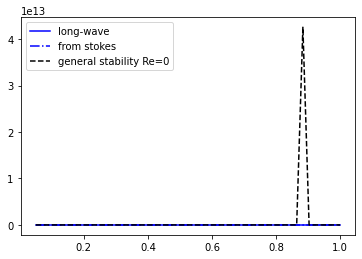

In [190]:
lambda_vect_thin = k_vect**2/3*(D_-epsilon**2*k_vect**2)*(1-alpha)**3
lambda_vect = k_vect**2/16*(epsilon**2*k_vect**2-D_)*((alpha**2-1)**2-2*(alpha**2-1-2*np.log(alpha)))
plt.plot(epsilon*k_vect, epsilon**2*lambda_vect, label='long-wave', color='blue')
plt.plot(k_vect*epsilon,epsilon**2*lambda_vect_thin,'-.' ,label='from stokes', color='blue')
plt.plot(kappa_vect, epsilon*Lambda_vect.real, '--', label ='general stability Re=0',color='black')
plt.legend()

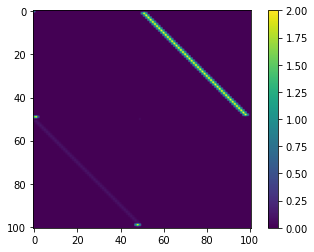

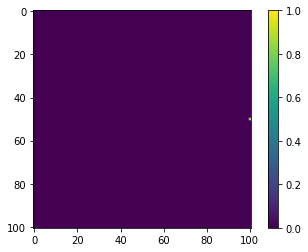

[2.95623999e+01-1.75716254e+03j 1.64326916e-15+6.81577472e-14j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.000000

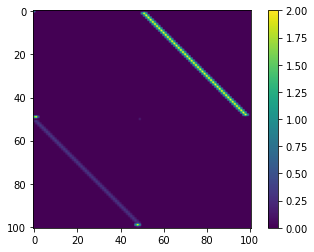

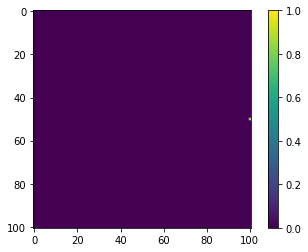

[ 2.91772333e+01-6.01722908e+02j -4.87351111e-15-9.67003655e-32j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.000000

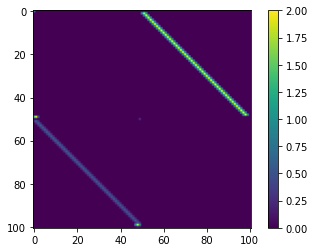

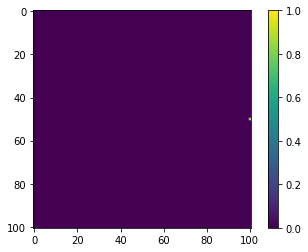

[ 2.77943741e+01-3.61227322e+02j -6.35340945e-15+2.91838692e-14j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.000000

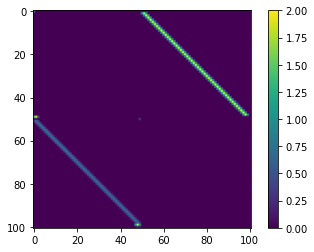

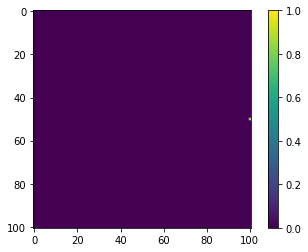

[ 2.57219742e+01-2.5737362e+02j -3.48845039e-30-6.2833967e-14j
  0.00000000e+00+0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.0000000e+00j
  0.00000000e+00-0.0000000e+00j  0.00000000e+00-0.00000

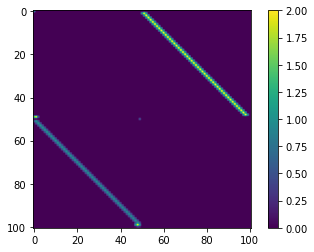

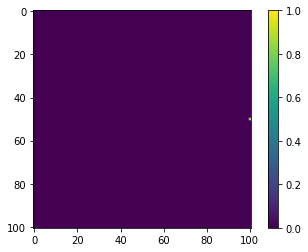

[ 2.30168864e+01-1.99672087e+02j -1.03454685e-14-1.04985245e-13j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.000000

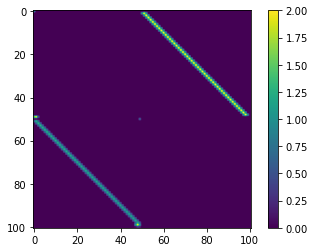

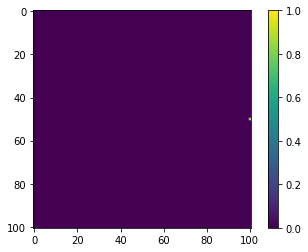

[1.97074900e+01-1.63217771e+02j 7.05786266e-15+4.08124548e-14j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.000000

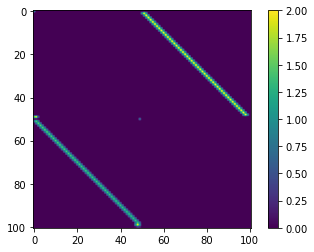

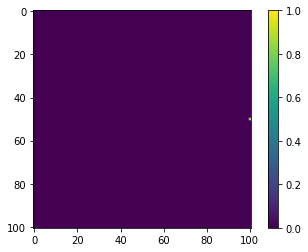

[ 1.57913793e+01-1.38337853e+02j -1.47663771e-14-1.01982907e-13j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.000000

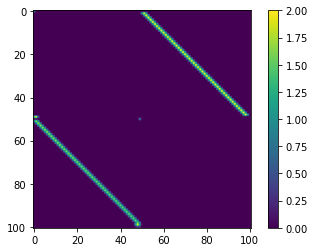

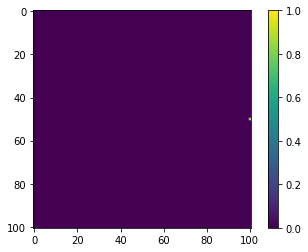

[1.12334515e+01-1.20406912e+02j 2.54529727e-15+3.59619597e-14j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.000000

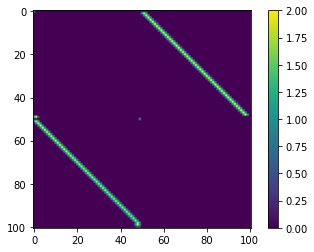

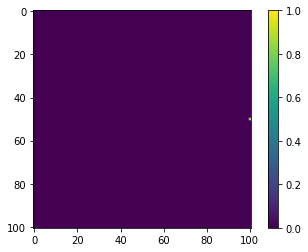

[ 5.97965214e+00-1.06820150e+02j -7.20820683e-15-1.69188301e-13j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.00000000e+00j  0.00000000e+00-0.00000000e+00j
  0.00000000e+00-0.000000

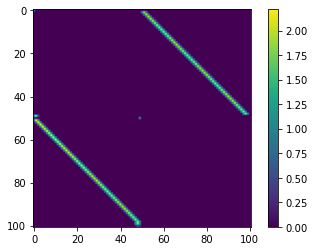

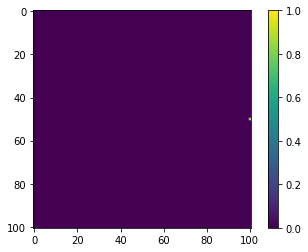

[6.73117419e-10-9.58574157e+01j 7.18855392e-26-2.81244109e-14j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00+0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00+0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.00000000e+00j
 0.00000000e+00-0.00000000e+00j 0.00000000e+00-0.000000

In [229]:
#better behaved matrix
alpha = 0.9; Re = 0; epsilon = 0.1; Bo = epsilon; Ca = epsilon; Ma = 0;
N = 50;
D_ = 1 - 2*Ma
r_list = np.linspace(alpha, 1, N); h = r_list[1]-r_list[0]
kappa_vect = np.linspace(0.05,1, 10)
#k_vect = kappa_vect/epsilon
Lambda_vect = np.zeros_like(kappa_vect, dtype='complex')
for j,k in enumerate(kappa_vect):
    def build_matrix_arnoldi():
        matrix_f_eq1 = np.zeros((N,N), dtype=float)
        matrix_p_eq1 = np.zeros((N,N), dtype=float)

        matrix_f_eq1[0,0] = 1; # no_slip for u at the wall (a_0=0)
        #matrix_b_continuity[-1,0] =1; # no_slip for u at the wall (b_0=0)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq1[j,j] = 2*k**2/r*w_0_prime(r)*Re*h**2
            matrix_p_eq1[j, j-1] = (1/(2*h*r)-1/h**2)*h**2
            matrix_p_eq1[j,j] = (2/h**2-k**2)*h**2
            matrix_p_eq1[j,j+1] =  (-1/h**2-1/(2*r*h))*h**2

        # df/dr =0
        matrix_f_eq1[-1, 0] =-3/2
        matrix_f_eq1[-1, 1] =2
        matrix_f_eq1[-1, 2] =-1/2
        matrix_eq1 = np.concatenate([matrix_f_eq1, matrix_p_eq1, np.zeros((N,1))], axis=1)
        
        matrix_f_eq2 = np.zeros((N+1,N), dtype=complex)
        matrix_p_eq2 = np.zeros((N+1,N+1), dtype=complex)
        for j, r in enumerate(r_list[1:-1]):
            j=j+1
            matrix_f_eq2[j,j-1] = (-1j*k/(2*h*r**2)-1j*k/(r*h**2))*h**2
            matrix_f_eq2[j,j] = (-2*1j/r**3 + 2*1j*k/(r*h**2) +1j*k**3/3+Re/r*(-k**2*w_0(r)))*h**2
            matrix_f_eq2[j, j+1] = (1j*k/(2*h*r**2)-1j*k/(r*h**2))*h**2
            matrix_p_eq2[j, j-1] = -1/(2*h)*h**2
            matrix_p_eq2[j,j+1] =  1/(2*h)*h**2

        #kinematic
        matrix_f_eq2[0, N-1] = -1j*k
        matrix_p_eq2[0, -1] = 1j*k*w_0(1)

        #tangential stress
        matrix_f_eq2[N-1, N-3] = (1/(2*h)-1/h**2)*h**2
        matrix_f_eq2[N-1, N-2] = (2/h**2-2/h)*h**2
        matrix_f_eq2[N-1, N-1] = (3/(2*h)-1/h**2-k**2)*h**2
        matrix_p_eq2[N-1, -1] = -1*h**2 

        #normal stress
        matrix_f_eq2[-1, N-3] = -1j*k*Ca/h*h
        matrix_f_eq2[-1, N-2] = 4*1j*k*Ca/h*h
        matrix_f_eq2[-1, N-1] = (-3*1j*k*Ca/h+2*1j*k*Ca)*h
        matrix_p_eq2[-1, N-1] = Bo*h
        matrix_p_eq2[-1,-1] = (1-2*Ma-k**2)*h
        matrix_eq2 = np.concatenate([matrix_f_eq2, matrix_p_eq2], axis=1)
        
        matrix_f_RHS_2 = np.zeros((N+1,N), dtype = complex) 
        matrix_p_RHS_2 = np.zeros((N+1,N+1), dtype = complex)
        
        matrix_p_RHS_2[0, -1] = 1
        for j, r in enumerate(r_list[1:-1]):
            matrix_f_RHS_2[j,j] = Re/r*1j*k*h**2
        matrix_RHS_1 = np.zeros_like(matrix_eq1)
        matrix_RHS_2 = np.concatenate([matrix_f_RHS_2, matrix_p_RHS_2], axis=1)
        
        return np.concatenate([matrix_eq1, matrix_eq2], axis=0), np.concatenate([matrix_RHS_1, matrix_RHS_2], axis=0)
    
    A,B = build_matrix_arnoldi()
    #print(A)
    plt.imshow(np.abs(A)); plt.colorbar()
    plt.show()
    plt.imshow(np.abs(B)); plt.colorbar()
    plt.show()
    evals_complex = scipy.linalg.eigvals(B,A)
    
    print(evals_complex)
    evals_filtered = evals_complex[np.abs(evals_complex)>1e-10]
    lambdas = evals_filtered.real/(np.abs(evals_filtered)**2)
    print(lambdas)
    Lambda_vect[j] = np.max(lambdas.real)
    print(Lambda_vect[j])
    print(j/len(kappa_vect)*100)

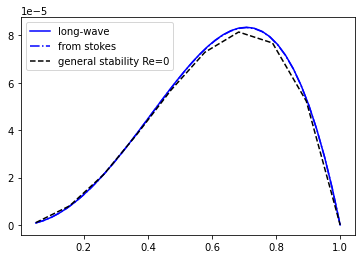

In [230]:
lambda_vect_thin = k_vect**2/3*(D_-epsilon**2*k_vect**2)*(1-alpha)**3
lambda_vect = k_vect**2/16*(epsilon**2*k_vect**2-D_)*((alpha**2-1)**2-2*(alpha**2-1-2*np.log(alpha)))
plt.plot(epsilon*k_vect, epsilon**2*lambda_vect, label='long-wave', color='blue')
plt.plot(k_vect*epsilon,epsilon**2*lambda_vect_thin,'-.' ,label='from stokes', color='blue')
plt.plot(kappa_vect, epsilon*Lambda_vect.real, '--', label ='general stability Re=0',color='black')
plt.legend()